In this project I will train two deep learning models to allow machines to identify key facial points in the human face with a Mean Squared Error smaller than 0.005. It allows us to improve biometric recognition, the early detection of deseases and let machines identify human emotions. So the applications are immense.

    TECHNIQUES:
    -Deep learning with tensorflow
    -Convolutional neural networks
    -Hiper parameters tunning with Grid and Random search
    -Techniques to decrease gradient loss and overfitting (Maximmun pooling and dropout)

This is how what we are doing looks like:

![Image Alt Text](output.png)

In [119]:
import numpy as np 
import pandas as pd 
import torch
from itertools import product
import torch.nn as nn
from sklearn.model_selection import train_test_split

Let us import and take a look on the data.

In [120]:
dt=pd.read_csv("C:\\Users\\USER\\Desktop\\Códigos\\Portifólio CNN keypoints predictions\\training.csv")
dt=dt.dropna()
dt.head()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,...,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774,238 236 237 238 240 240 239 241 241 243 240 23...
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,...,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170,219 215 204 196 204 211 212 200 180 168 178 19...
2,65.057053,34.909642,30.903789,34.909642,59.412000,36.320968,70.984421,36.320968,37.678105,36.320968,...,53.538947,60.822947,73.014316,33.726316,72.732000,47.274947,70.191789,47.274947,78.659368,144 142 159 180 188 188 184 180 167 132 84 59 ...
3,65.225739,37.261774,32.023096,37.261774,60.003339,39.127179,72.314713,38.380967,37.618643,38.754115,...,54.166539,65.598887,72.703722,37.245496,74.195478,50.303165,70.091687,51.561183,78.268383,193 192 193 194 194 194 193 192 168 111 50 12 ...
4,66.725301,39.621261,32.244810,38.042032,58.565890,39.621261,72.515926,39.884466,36.982380,39.094852,...,64.889521,60.671411,77.523239,31.191755,76.997301,44.962748,73.707387,44.227141,86.871166,147 148 160 196 215 214 216 217 219 220 206 18...


Data preparation:
- Get a new dataset with only two columns, a 15x12 torch containning the positions (x,y) of the 15 keypoints and another column with the image as another torch. Both will be normalized to the range [-1,1] as it greatly increases performance.
- Split the data into train, test and validation.
- Turn the datasets into tuples with two elements, the positions and the images as it is better suited for the former model.

In [121]:
new_dt = pd.DataFrame()

#Get a column with 15 tuples containning the positions (x,y) of the points inside 15x2 tensors
keypoints = dt.iloc[:,:30] #Get only the columns with the keypoints positions

def get_positions(row):
    "Row of the data points of the dataset in different columns -> torch with the x,y positions of the keypoints"
    positions = row.tolist()
    positions = torch.tensor(positions).view((15,2))
    normalized_positions = 2*(positions / 255.0)-1
    return normalized_positions

new_dt['keypoints'] = keypoints.apply(get_positions, axis=1)


In [122]:
def image_prep(image):
    """Receives an Image as a sequence of numbers and returns a 96X96 torch tensor"""
    values = [int(value) for value in image.split()]
    n_image = torch.tensor(values).view((96,96))
    normalized_images = 2*(n_image / 255.0)-1

    return normalized_images

new_dt['Image'] = dt.Image.apply(image_prep)

In [123]:
#Let us get 80% of the data for trainning, 15% for testing and 5% of the total dataset
#for validation at the end.
train_dt, not_train_dt = train_test_split(new_dt, test_size=0.2)
test_dt, val_dt = train_test_split(not_train_dt, test_size=0.25)

In [124]:
def to_tuple(data):
    keypoints = torch.cat(data.keypoints.to_list()).view((-1,15,2))
    images = torch.cat(data.Image.to_list()).view((-1,1,96,96))
    return (images,keypoints)
    
train = to_tuple(train_dt)
test = to_tuple(test_dt)
val = to_tuple(val_dt)

Now we will create the model, it consists of a Convolutional Neural Network with hiperparameters defined in a dictionary for later fine tunning.  

The architecture is the following, there are 3 "Packs", each containing one convolutional, one Relu, another convolutional, another Relu, one maxpooling layer and one dropout layer.

- The Convolutional layers process the images itself, getting the parameters that will be improved on and, in the end, selecting the important features. It has way fewer parameters than a 'common' linear layer, so it is much more efficient.

- The Relu's are the activation functions, they are important for making the model non-linear, improving it's capacity for complex features processing. Specifically, I used Relu because it does not saturate on 1 for extreme values and it converges quickly.

- The Max Pooling in a certain way filters the image so that it keeps only the most important pixels, making the model faster.

- The dropout helps the model identify the truly important features, since it turns of certain neurons, so it makes the training harder, keeping it from overfitting and improves the performance.

In the end, the data coming from the model is flattened so the linear classifier can finally give us the estimated keypoints.

In [125]:
def calc_dim(packs, hparams):
    """
    Returns the dimension of the data after the convolutional packs 
    """
    kernel_size=hparams['kernel_size']
    padding=hparams['padding']
    stride=hparams['stride']
    h=96
    for i in range(packs):#It considers one CNN and one maxpooling functions per pack
        h=(1+((h-kernel_size+2*padding)//stride))
        h=(1+((h-kernel_size+2*padding)//stride))
        h=(1+((h-2)//2))#We won't use padding in maxpooling, and kernel_size=stride=2
    return h

class KeypointModel(nn.Module):
    """Facial keypoint detection model"""
    def __init__(self, hparams):
        
        super().__init__()
        self.hparams = hparams

        kernel_size=self.hparams['kernel_size']
        stride=self.hparams['stride']
        padding=self.hparams['padding']
        out_channel=self.hparams['out_channel'] 

        last_dim=out_channel*int(calc_dim(3, hparams=hparams)**2) #Squared because the function returns one dimension, times the amount of channels

        self.model = nn.Sequential( 

            #Pack 1
            nn.Conv2d(
                    in_channels=1,
                    out_channels=out_channel,
                    kernel_size=kernel_size,
                    stride=stride,
                    padding=padding),
            nn.ReLU(),
            nn.Conv2d(in_channels=out_channel,
                    out_channels=out_channel,
                    kernel_size=kernel_size,
                    stride=stride,
                    padding=padding),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2,stride=2),#Faz sentido usar stride e padding aq?
            nn.Dropout(),

            #Pack 2
            nn.Conv2d(in_channels=out_channel,
                    out_channels=out_channel,
                    kernel_size=kernel_size,
                    stride=stride,
                    padding=padding),
            nn.ReLU(),
            nn.Conv2d(in_channels=out_channel,
                    out_channels=out_channel,
                    kernel_size=kernel_size,
                    stride=stride,
                    padding=padding),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2,stride=2),
            nn.Dropout(),

            #Pack 3
            nn.Conv2d(in_channels=out_channel,
                    out_channels=out_channel,
                    kernel_size=kernel_size,
                    stride=stride,
                    padding=padding),
            nn.ReLU(),
            nn.Conv2d(in_channels=out_channel,
                    out_channels=out_channel,
                    kernel_size=kernel_size,
                    stride=stride,
                    padding=padding),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2,stride=2),
            nn.Dropout(),

            #Final layer
            nn.Flatten(),
            nn.Linear(last_dim, 30)
        )

    def forward(self, x):
                    
        x=self.model(x)
        x=x.view(int(x.shape[0]),15,2)

        return x

Now we will create two functions, one that generates the batches for our model and another that trains it.

In [126]:
def prepare_batches(data,batch_size):
    """Returns a dictionary with tuples consisting of the images and the keypoints of each batch (b_img, b_key) """
    images, keypoints= data[0], data[1]
    n_batches=int(len(images)/batch_size)
    batches={}    
    for i in range(1,n_batches+1):
        #Pegar batch size amostras do dataset com as imagens e os pontos
        b_img=images[(i-1)*batch_size:i*batch_size]
        b_key=keypoints[(i-1)*batch_size:i*batch_size]
        batches[i]=(b_img,b_key)
    return batches

For the trainning we are foing to use the Mean Squared Error, since it punishes big discrepancies much more heavily.

Besides, we will use the Adaptive Moment Estimation optimizer, Adam, since it uses stochastic gradient descent (faster convergence), but also uses Momentum, keeping the model to get stuck in a local optimum. 

The function prints the losses over the iterations and the validation loss after each epoch.

In [127]:
def train_model(train_dataset, test_dataset, model, hparams):
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(params=model.parameters(),lr=hparams['lr'],weight_decay=hparams['lr_decay'])
    batches = prepare_batches(train_dataset, batch_size = hparams['batch_size'])
    test_img, test_key = test_dataset
    total_losses = {}
    test_losses = {}
    #Run the model on many x values and print the losses over time.
    
    for epoch in range(hparams['epochs']):
        model.train()
        losses=[]
        
        for i in range(1,len(batches)+1):
            optimizer.zero_grad()
            batch=batches[i]
            b_img=batch[0]
            b_key=batch[1]
            #Make predictions and evaluate results
            pred=model(b_img.float())
            loss=criterion(pred,b_key.float())
            loss.backward() #Backpropagation for improving our parameters.
            losses.append(float(loss))
            optimizer.step()

        with torch.no_grad():#We don't want to fit on the test data
            pred_test = model(test_img.float())
            loss = criterion(pred_test,test_key.float())  
            test_losses[epoch]=float(loss)

        total_losses[epoch]=losses
    return [total_losses, test_losses]

In [128]:
"""param_grid = {
    'kernel_size':[3,5],
    'stride':[1],
    'padding':[1],
    'out_channel':[1,2,3],
    'batch_size':[32,64],
    'lr':[0.1,0.01,0.001],
    'lr_decay':[0.1,0.01,0.001],
    'epochs':[1]}#Since we have many tests to do, let us keep the epochs low for now

hiper_dic={}
for pack in product(*param_grid.values()):
    hparams={
        'kernel_size':pack[0],
        'stride':pack[1],
        'padding':pack[2],
        'out_channel':pack[3],
        'batch_size':pack[4],
        'lr':pack[5],
        'lr_decay':pack[6],
        'epochs':pack[7]}
    print(hparams)
    hiper_dic[str(hparams)]=train_model(train,test,model,hparams)"""

"param_grid = {\n    'kernel_size':[3,5],\n    'stride':[1],\n    'padding':[1],\n    'out_channel':[1,2,3],\n    'batch_size':[32,64],\n    'lr':[0.1,0.01,0.001],\n    'lr_decay':[0.1,0.01,0.001],\n    'epochs':[1]}#Since we have many tests to do, let us keep the epochs low for now\n\nhiper_dic={}\nfor pack in product(*param_grid.values()):\n    hparams={\n        'kernel_size':pack[0],\n        'stride':pack[1],\n        'padding':pack[2],\n        'out_channel':pack[3],\n        'batch_size':pack[4],\n        'lr':pack[5],\n        'lr_decay':pack[6],\n        'epochs':pack[7]}\n    print(hparams)\n    hiper_dic[str(hparams)]=train_model(train,test,model,hparams)"

After taking a look in the hiperdic, we discover that the following set of hiper-parameters performed very well. Lets train our model on it.

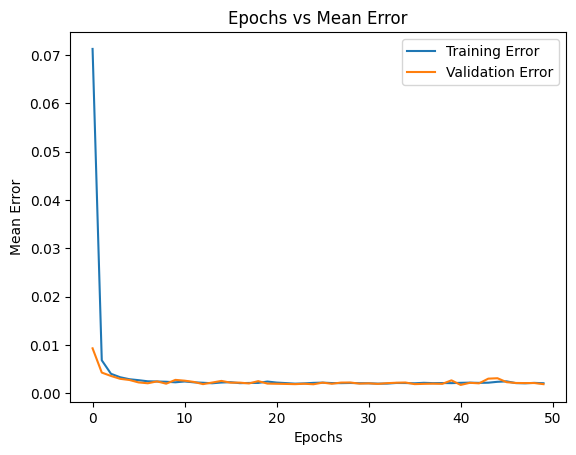

In [129]:
hparams = {'kernel_size': 5, 'stride': 1, 'padding': 1, 'out_channel': 2, 'batch_size': 64, 'lr': 0.01, 'lr_decay': 0.001, 'epochs': 50}
model=KeypointModel(hparams)
train_data = train_model(train, test, model, hparams)
#Let us plot the evolution of the error, the train error is the first element and the test is the second.
import matplotlib.pyplot as plt
epochs = list(train_data[0].keys())
mean_errors = [sum(errors) / len(errors) for errors in train_data[0].values()]

plt.plot(epochs, mean_errors, label='Training Error')
plt.plot(epochs, train_data[1].values(), label='Validation Error')
plt.xlabel('Epochs')
plt.ylabel('Mean Error')
plt.title('Epochs vs Mean Error')
plt.legend()
plt.show()

Let us check the error in the validation data:

In [130]:
criterion = torch.nn.MSELoss()
val_img, val_key = val
pred=model(val_img.float())
loss=criterion(pred,val_key.float())
print(loss.float())

tensor(0.0020, grad_fn=<MseLossBackward0>)


Success! We got an error in the validation data smaller than 0.005! 

Things to improve:

    - Use DataLoader instead of a self made dataloader for the batches.
    - Improving the function of hiperparameters tunning for better visualization of the errors and parameters.
    - Use random search for even better hiperparemeters tunning.
    - Use data augmentation such as rotating the images, changing the images brightness, setting a gaussian filter, all these could increase the trainning data and performance.
     